**USE GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('./mount')

**IMPORT**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

**NETWORKS**

In [ ]:

class MnistDataset(Dataset):
    def __init__(self, path):
        """
        Load data in class
        """
        # CSV reader
        data_file = open("mount/My Drive/Colab Notebooks/mnist/mnist_train.csv", 'r')
        self.data_df = data_file.readlines()
        data_file.close()

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        """
        Get from 'for loop' (label, tensor raw image, target of image (what should NN output))
        """
        img = list(map(int, self.data_df[index].split(',')))
        label = img[0]
        target = torch.zeros((10))
        target[label] = 1.0
        img_values = torch.cuda.FloatTensor(img[1:]) / 255.0

        return label, img_values, target

    def plot(self, index):
        """
        Plot (show) targeted (index) image
        """
        img = list(map(int, self.data_df[index].split(',')))
        arr = np.array(img[1:]).reshape(28, 28)
        plt.title("label = " + str(img[0]))
        plt.imshow(arr, interpolation="none", cmap="Blues")


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        """Reshape to another dimensnsion"""
        self.shape = shape, # <- create tuple
    
    def forward(self, x):
        return x.reshape(*self.shape)



class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        """
        Create structure of NN
        """

        # Neural Network layers
        self.model = nn.Sequential(
            View((1, 1, 28, 28)),
            nn.Conv2d(1, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),

            View(1)
            )

        # Binary cross entropy loss -> better for classification than MSELoss
        self.loss_function = nn.BCELoss()

        # Adam optimiser; better for this task than Stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Timestap of loss for ploting progress
        self.progress = []
        self.counter = 0

    def forward(self, inputs):
        """
        Pass through NN and get its answer
        """
        return self.model(inputs)

    def train(self, inputs, targets):
        """
        Train NN; Take tensor of image with label identificator of image;
        Pass through NN; get loss/cost function and backpropagate NN
        to tweak weights (layers)
        """
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)

        # Backpropagation
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        # Timestamp
        self.counter += 1
        if self.counter % 100 == 0:
            self.progress.append(loss.item())


    def plot_progress(self):
        """
        Plot loss of NN for every image it was trained
        """
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", grid=True,
                yticks=(0, 0.25, 0.5, 0.1, 5.0), title="Discriminator Loss")


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        """
        Create structure of NN
        """
        # Only for convinienct in main.py
        self.input_size = 100
        # Neural Network layers
        self.model = nn.Sequential(
            # reshape to z (_, z, y, x)
            View((1, 100, 1, 1)),
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),

            View((28, 28))
            )

        # No loss function; will use one from discriminator to calculate error

        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Timestap of loss for ploting progress
        self.progress = []
        self.counter = 0

    def forward(self, inputs):
        """
        Pass through NN and get its answer
        """
        return self.model(inputs)

    def train(self, D, inputs, targets):
        """
        Train NN; Take tensor of image with label identificator of image;
        Pass through NN; get loss/cost function and backpropagate NN
        to tweak weights (layers)
        """
        g_output = self.forward(inputs)
        d_outputs = D.forward(g_output)

        loss = D.loss_function(d_outputs, targets)

        # Backpropagation
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1
        if self.counter % 100 == 0:
            self.progress.append(loss.item())

    def plot_progress(self):
        """
        Plot loss of NN for every image it was trained
        """
        
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, 
                yticks=(0, 0.25, 0.5, 0.1, 5.0), title="Generator Loss")

**FUNCTIONS**

In [ ]:
def plot_networks_outputs(save=True):
    """
    Plot loss function through time and generator outputs
    """
    # Loss function
    D.plot_progress()
    G.plot_progress()

    # Plot Generator output
    fig, ax = plt.subplots(2, 3, figsize=(16, 8))
    fig.canvas.set_window_title("Generator outputs") 
    for i in range(2):
        for j in range(3):
            output = G.forward(generate_random_seed(100))
            img = output.detach().cpu().numpy().reshape(28, 28)
            ax[i,j].imshow(img, interpolation="none", cmap="Blues")
    if save == True:
      PATH = "mount/My Drive/Colab Notebooks/mnist/generated images/generator output.png"
      plt.savefig(PATH)

def plot_outputs_in_time(evolution, plot_size, together=True, save=True):
    if together == True:
        """
        Plot Generator outputs through epochs
        """
        fig, ax = plt.subplots(1, plot_size+1, figsize=(16, 8))
        fig.canvas.set_window_title("Generator outputs through epochs.") 
        for index, g_output in enumerate(evolution):
            img = g_output.detach.cpu().numpy().reshape(28, 28)
            ax[index].imshow(img, interpolation="none", cmap="Blues")
        if save == True: 
            PATH = "mount/My Drive/Colab Notebooks/mnist/generated images/results after each epochs.png"
            plt.savefig(PATH)
    else:
        """
        Save plots of G output in first epoch
        """
        fig, ax = plt.subplots(figsize=(16, 8))
        for index, g_output in enumerate(evolution):
            img = g_output.detach().cpu().numpy().reshape(28, 28)
            plt.imshow(img, interpolation="none", cmap="Blues")
            if save == True: 
                PATH = f"mount/My Drive/Colab Notebooks/mnist/generated images/{index}.png"
                plt.savefig(PATH)


def save_model(G, D, state_dict=True):
    if state_dict == True:
      PATH = "mount/My Drive/Colab Notebooks/mnist/models/generator.pt"
      torch.save(G.state_dict(), PATH)
      PATH = "mount/My Drive/Colab Notebooks/mnist/models/discriminator.pt"
      torch.save(D.state_dict(), PATH)
    else:
      PATH = "mount/My Drive/Colab Notebooks/mnist/models/generator.pt"
      torch.save(G, PATH)
      PATH = "mount/My Drive/Colab Notebooks/mnist/models/discriminator.pt"
      torch.save(D, PATH)


def generate_random_seed(i): 
    return torch.randn(i)

**CUDA**

In [ ]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**PREPARE NETWORKS**

In [ ]:
path = "mount/My Drive/Colab Notebooks/mnist/mnist_train.cvs"
dataset = MnistDataset(path)

D = Discriminator().to(device)
G = Generator().to(device)

**LOAD NETWORKS** (In case of disconnection in training)

In [ ]:
PATH = "mount/My Drive/Colab Notebooks/mnist/models/discriminator.pt"
D.load_state_dict(torch.load(PATH))
PATH = "mount/My Drive/Colab Notebooks/mnist/models/generator.pt"
G.load_state_dict(torch.load(PATH))

**TRAIN**

Training in 1 / 10 epochs...



Training in 2 / 10 epochs...



Training in 3 / 10 epochs...



Training in 4 / 10 epochs...



Training in 5 / 10 epochs...



Training in 6 / 10 epochs...



Training in 7 / 10 epochs...



Training in 8 / 10 epochs...



Training in 9 / 10 epochs...



Training in 10 / 10 epochs...



Training is done and model is saved.


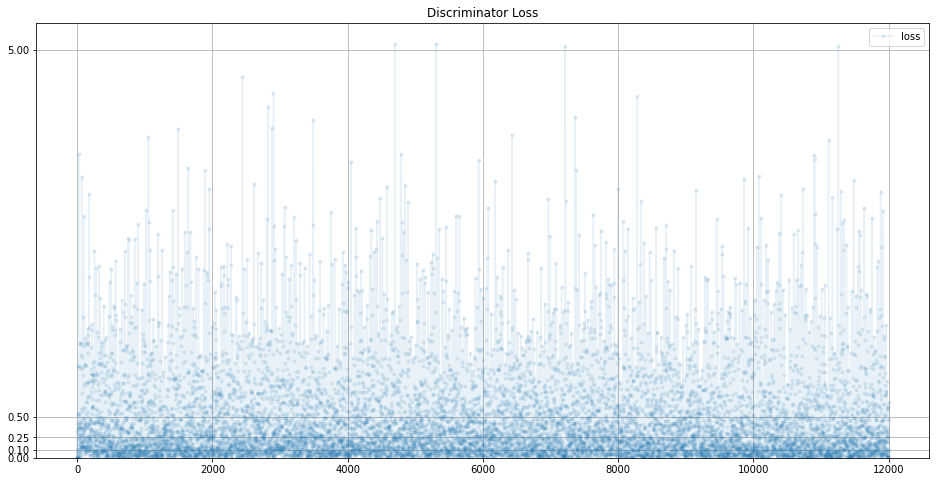

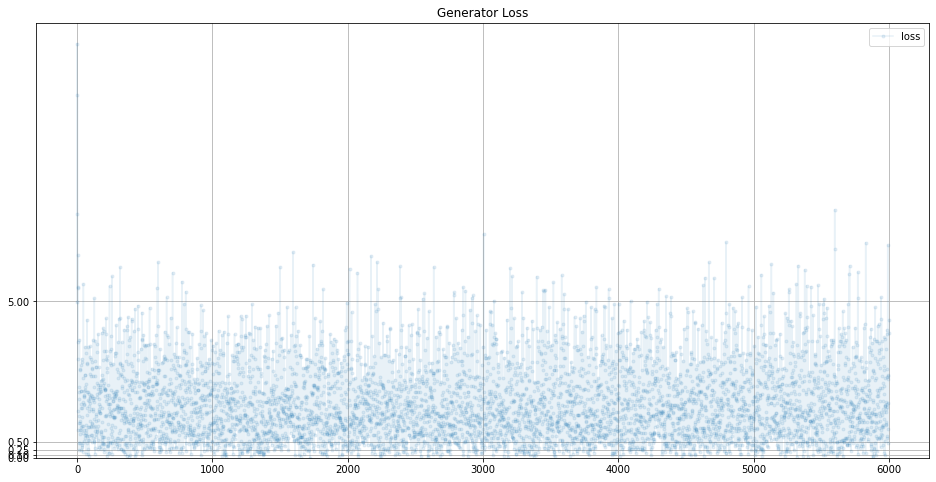

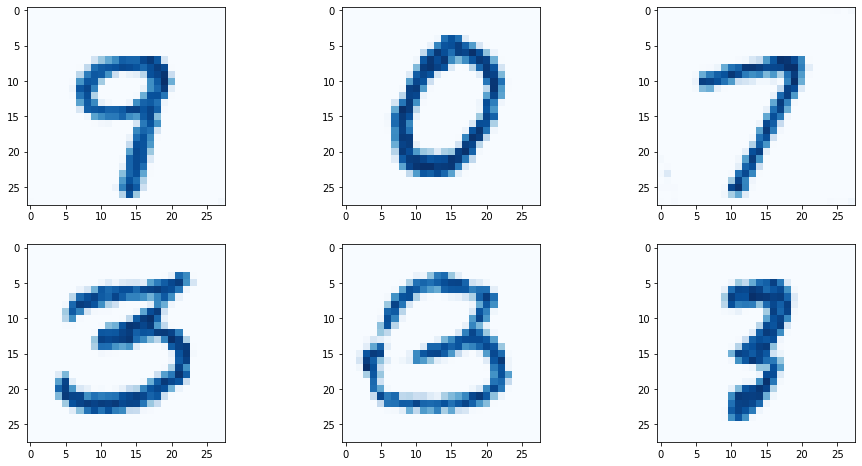

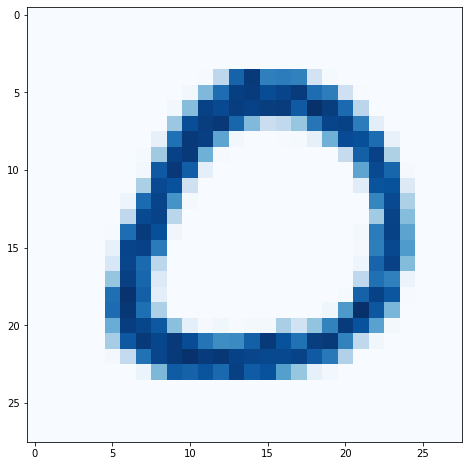

In [ ]:
seed1 = generate_random_seed(100)
evolution_in_epochs = [G.forward(seed1).detach()]
evolution_through_epochs = [G.forward(seed1).detach()]

epochs = 10
for e in range(1, epochs+1):
    print(f"Training in {e} / {epochs} epochs...")
    for dx, (label, img_data_tensor, target_tensor) in tqdm(enumerate(dataset), total=len(dataset)):
    #for dx, (label, img_data_tensor, target_tensor) in enumerate(dataset):
        # 1.0 for image from real dataset; 0.0 for fake one

        # train D on real/true data
        D.train(img_data_tensor, torch.cuda.FloatTensor([1.0]))

        # train D on fake/false data
        # detach() to not calculate gradients in G (for computational cost)
        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

        # train G (generator)
        G.train(D, generate_random_seed(100).detach(), torch.cuda.FloatTensor([1.0]))

        if (dx+1) % 1000 == 0:
            # Save progress
            evolution_in_epochs.append(G.forward(seed1).detach())
            #print(f"Trained on {dx+1} / {len(dataset)} images in {e} / {epochs} epochs...")

    # Save progress
    evolution_through_epochs.append(G.forward(seed1).detach())

    # save models
    save_model(G, D)


### PLOT ###
plot_networks_outputs()
plot_outputs_in_time(evolution_through_epochs, epochs, together=False)
#plot_outputs_in_time(evolution_in_epochs, epochs, together=False)

print("Training is done and model is saved.")

**MEMORY**

In [ ]:
print(torch.cuda.memory_summary(device, abbreviated=True))